In [ ]:
import moments
import numpy as np
import matplotlib.pyplot as plt
import torch
from sbi.utils import MultipleIndependent
from torch.distributions import Beta, Binomial, Gamma
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.utils.user_input_checks import process_prior, process_simulator
from torch import nn
import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR) # See: https://github.com/matplotlib/matplotlib/issues/14523


In [2]:
sample_size = 60
torch.manual_seed(42)
num_trials = 10
num_samples = 1000
#the_device = 'cuda' if torch.cuda.is_available() else 'cpu'
the_device = 'cpu'
iid = 50  # number of independent samples, but with the same selection coefficeint (i.e. [P(X_1 | gamma_1), P(X_2 | gamma_1), ... , P(X_iid | gamma_1)])
prior_returns_numpy = True # Prior needs to be in numpy format for simulator
default_network_type = "nsf" # TODO change default network to integer discrete flows
num_hidden = 64
number_of_transforms = 3
num_sim = 100 # Number of simulations, number of simulations should increase when number of parameters in the simulation increase
rounds = 10 # Number of rounds to train/simulate
posterior_type = "VI"


In [495]:
the_device='cpu'

In [24]:
def moment_sim_demo(prior):
    """Uses Moments (cite) to create simulated Site Frequency Spectrums of a demographic history

    Args:
        prior (float): a sampled selection distribution from a prior distribution

    Returns:
        x: The sampled site-frequency spectrum based on moments via Poisson(E[X | gamma]) where gamma = prior
        Output of the simulator needs to be float32 based on SBI format 
    """    
    #prior = prior.cpu().numpy()
    nuB = prior[0]
    nuF = prior[1]
    etime = prior[2]
    theta = prior[3]
    # nuB = prior[0, 0]
    # nuF = prior[0, 1]
    # etime = prior[0, 2]
    # theta = prior[0, 3]
    moment_data =  moments.Demographics1D.bottlegrowth([nuB, nuF, etime], [sample_size]) 
    moment_data = theta * moment_data
    # masked arrays are objects and data is accessed through .data attribute or valid data through .compressed()
    data = moment_data.sample()
        
    return torch.tensor((data[1:-1]), device=the_device).type(torch.float32)


In [25]:
multiprior = MultipleIndependent(
    [
        torch.distributions.Uniform(torch.tensor([0.1], device=the_device), torch.tensor([0.5], device=the_device)),
        torch.distributions.Uniform(torch.tensor([1.0], device=the_device), torch.tensor([5.0], device=the_device)),
        torch.distributions.Uniform(torch.tensor([1.0], device=the_device), torch.tensor([5.0], device=the_device)),
        torch.distributions.Uniform(torch.tensor([1000.0], device=the_device), torch.tensor([3000.0], device=the_device))
    ],
    validate_args=False,
)

prior, num_parameters, prior_returns_numpy = process_prior(multiprior)


In [26]:
simulator = process_simulator(moment_sim_demo, prior, prior_returns_numpy)


In [21]:
print(simulator)

<function get_batch_loop_simulator.<locals>.batch_loop_simulator at 0x7f57d1192290>


In [27]:
# First learn posterior
density_estimator_function = posterior_nn(model="nsf", hidden_features=num_hidden, num_transforms=number_of_transforms)
infer_posterior = SNPE(prior, show_progress_bars=True, device=the_device, density_estimator=density_estimator_function)


In [14]:
theta_o = prior.sample((1,)).cpu().numpy()
theta_o[0,1]


2.1172435

In [28]:
theta_o.shape

(1, 4)

In [28]:
#x_o = moment_sim(theta_o.repeat(num_trials, 1))
x_o = moment_sim_demo(theta_o)
print(x_o)

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [10]:
posteriors = []
posteriors2 = []

In [11]:
vi_parameters = {"q": "nsf", "parameters": {"num_transforms": 3, "hidden_dims": 32, "skip_connections": True, "nonlinearity": nn.SiLU()}}


In [ ]:
proposal = prior
rounds = 100
num_sim = 100
for i in range(0,rounds):

    theta, x = simulate_for_sbi(simulator, proposal, num_sim)
    liklihood_estimator = infer_posterior.append_simulations(theta, x, proposal=proposal)
    liklihood_estimator = liklihood_estimator.train(training_batch_size=50, discard_prior_samples=True)
    print("\n ****************************************** Building Posterior for round {} ******************************************.\n".format(i))

    posterior = infer_posterior.build_posterior(density_estimator=liklihood_estimator, sample_with = "vi", vi_method="rKL", vi_parameters=vi_parameters)
    posteriors.append(posterior)
    posterior = posterior.set_default_x(x_o).train()
    proposal = posterior
    posteriors2.append(posterior)


In [30]:
posterior_samples = posteriors2[-1].sample((500,))

In [89]:
posterior_samples

tensor([[1.5104e-01, 1.5330e+00, 1.9431e+00, 2.3857e+03],
        [4.6879e-01, 3.5311e+00, 4.2297e+00, 1.0642e+03],
        [2.4723e-01, 2.0932e+00, 2.9139e+00, 1.5482e+03],
        [2.4700e-01, 2.2658e+00, 3.2922e+00, 1.5064e+03],
        [2.5383e-01, 2.4924e+00, 4.2141e+00, 1.3478e+03],
        [3.9308e-01, 2.8523e+00, 3.9526e+00, 1.1630e+03],
        [2.0267e-01, 1.4904e+00, 2.0371e+00, 2.3022e+03],
        [2.3016e-01, 1.7932e+00, 2.3883e+00, 1.8961e+03],
        [2.6624e-01, 2.3467e+00, 2.9830e+00, 1.4893e+03],
        [3.4519e-01, 2.6972e+00, 2.9945e+00, 1.3608e+03]], device='cuda:0')

In [32]:
from sbi.analysis import pairplot


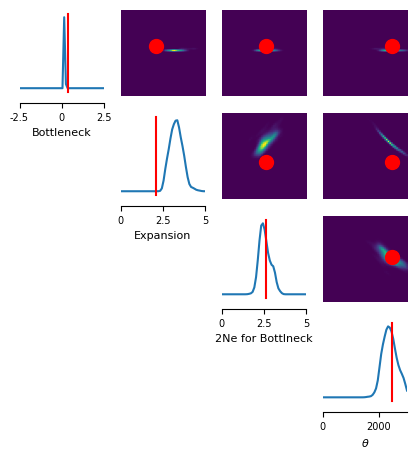

In [33]:
fig, ax = pairplot(
    samples=posterior_samples.cpu().numpy(),
    points=theta_o,
    limits=torch.tensor([[-2.5, 2.5], [0, 5.0], [0, 5], [0, 3000]]),
    upper=["kde"],
    diag=["kde"],
    figsize=(5, 5),
    labels=[rf"Bottleneck", "Expansion", "2Ne for Bottlneck", rf"$\theta$"],
    points_colors='r'
)

In [124]:
posterior_samples = posteriors2[-1].sample((500,))

In [34]:
x_pp = simulator(posterior_samples)
x_pp.shape

torch.Size([500, 59])

In [35]:
D = 10 # number of bins to plot
x_pp2 = x_pp[:, :D].cpu().numpy()
x_o2 = x_o[:D].cpu().numpy()


In [120]:
x_o2

array([3176., 1372.,  919.,  619.,  497.], dtype=float32)

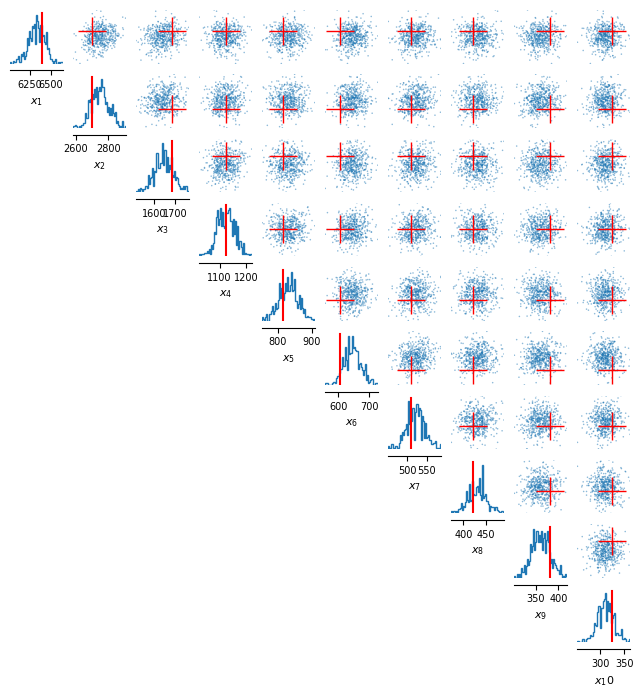

In [36]:
_ = pairplot(
    samples=x_pp2,
    points=x_o2,
    points_colors="red",
    figsize=(8, 8),
    upper="scatter",
    scatter_offdiag=dict(marker=".", s=5),
    points_offdiag=dict(marker="+", markersize=20),
    labels=[rf"$x_{d+1}$" for d in range(D)],)



In [142]:
from mom_functions import *

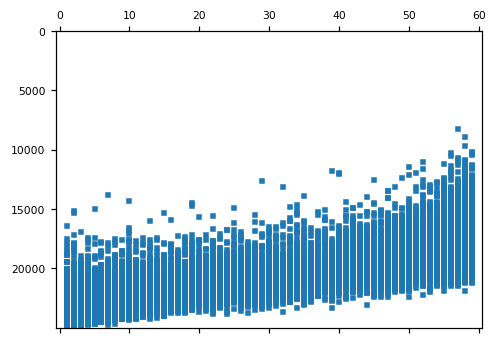

In [143]:
## generating the expected SFS (dimension: # of gens x # of samples):
numgens = 25000; sampsize = 60; gamma = -20; Neff = 10000; theta = 2000
fsa = run_mom_iterate_constant(numgens, sampsize, -gamma/Neff, Neff, theta, {})
fsa[fsa<0] = -fsa[fsa<0]
## for density, need to normalize
fsa_den = fsa/fsa.sum()
## for generating samples, use a Poisson to sample from *each* bin
SMS = rng.poisson(fsa) # need to draw samples from expectation, *not* density
plt.spy(SMS,aspect='auto',markersize=2) # sparse matrix

#a = SMS[:,1] # Gets counts of ages in frequency bin 1
#temp = np.argwhere(a>0.0) # Gets counts of ages in frequency bin 1 larger than 0

In [213]:
SMS.shape

(25000, 61)

In [297]:
paddingh = 2
dilationh = 1
kernelh = 64
strideh = 2
paddingw = 2
dilationw = 1
kernelw = 13
stridew = 1

In [239]:
h_out = ((SMS.shape[0]+ 2*paddingh - dilationh * (kernelh -1) -1 )/strideh) + 1
w_out = ((SMS.shape[1]+ 2*paddingw - dilationw * (kernelw -1) -1 )/stridew) + 1

In [263]:
print(h_out)
print(w_out)

12003.0
60.0


In [298]:
h_out2 = ((116+ 2*paddingh - dilationh * (kernelh -1) -1 )/strideh) + 1
w_out2 = ((26+ 2*paddingw - dilationw * (kernelw -1) -1 )/stridew) + 1

In [299]:
print(h_out2)
print(w_out2)

29.0
18.0


In [266]:
test = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1000, 6), stride=(2, 1), padding=1).to('cuda')

In [268]:
test3 = nn.MaxPool2d(kernel_size=(1000, 6), stride=(2, 1), padding=1).to('cuda')

In [285]:
test4 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1000, 16), stride=(2, 1), padding=1).to('cuda')

In [295]:
test5 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(400, 16), stride=(2, 1), padding=1).to('cuda')

In [300]:
test6 = nn.MaxPool2d(kernel_size=(64, 13), stride=(2, 1), padding=1).to('cuda')

In [314]:
test7 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(128, 12), stride=(2, 1), padding=1).to('cuda')

In [319]:
test8 = nn.MaxPool2d(kernel_size=(64, 8), stride=(2, 1), padding=1).to('cuda')

In [256]:
sms2 = torch.tensor(SMS, device='cuda').type(torch.float32)

In [257]:
sms2.type()

'torch.cuda.FloatTensor'

In [479]:
test8(test7(test6(test5(test4(test3(test(sms2.unsqueeze(0)))))))).shape

RuntimeError: cuDNN error: CUDNN_STATUS_MAPPING_ERROR

In [240]:
print(h_out)
print(w_out)

12003.0
60.0


In [467]:
class freq_and_age(nn.Module):
    def __init__(self):
        super(freq_and_age, self).__init__()
        self.cnn =  nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1000, 6), stride=(2, 1), padding=2) # outshape 32*120002*58
        self.max1 = nn.MaxPool2d(kernel_size=(1000, 6), stride=(2, 1), padding=1) # outshape 32*5503*58
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(400, 16), stride=(2, 1), padding=1) # output shape 16, 2253, 42
        self.cnn3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(400, 16), stride=(2, 1), padding=1) # torch.Size([8, 928, 29])
        self.max2  = nn.MaxPool2d(kernel_size=(64, 13), stride=(2, 1), padding=1) # torch.Size([8, 434, 19])
        self.cnn4 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(128, 12), stride=(2, 1), padding=1) # torch.Size([8, 155, 10])
        self.max3  = nn.MaxPool2d(kernel_size=(64, 8), stride=(2, 1), padding=1)  # torch.Size([8, 47, 5])
        self.lin1 = nn.Linear(8*47*5, out_features=128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64+60, 62)
        self.lin4 = nn.Linear(62, 16)


    def forward(self, data):
        ages = data[:,:-1,:].unsqueeze(1) # everything but the last row is count of ages shape is Batches * 1 Channel * Generations * Bins
        print("ages")
        print(ages.shape)
        freq = data[:,-1, :].unsqueeze(1) # last row is frequency counts shape is Batches * 1 Channel * Bins
        print("ages")
        print("freq")

        print(freq.shape)
        x1 = self.lin2(self.lin1(self.max3(self.cnn4(self.max2(self.cnn3(self.cnn2(self.max1(self.cnn(ages)))))))))
        
        x2 = freq
        
        x = torch.cat((x1, x2), dim=1)
        x = nn.SiLU(self.lin4(self.lin3(x)))
        
        return x


In [468]:
embedding_net = freq_and_age().to('cuda')


In [373]:
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

In [440]:
def moment_sim_demo_ages(prior):
    """Uses Moments (cite) to create simulated Site Frequency Spectrums of a demographic history

    Args:
        prior (float): a sampled selection distribution from a prior distribution

    Returns:
        x: The sampled site-frequency spectrum based on moments via Poisson(E[X | gamma]) where gamma = prior
        Output of the simulator needs to be float32 based on SBI format 
    """    
    prior = prior.cpu().numpy()[0]
    #print(prior.shape)
    #print(prior)
    moment_data =  moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(61, gamma=prior, theta=2000.0))  # returns a masked array
    
    # masked arrays are objects and data is accessed through .data attribute or valid data through .compressed()
    actual_fs = moment_data.compressed()  
    x = torch.poisson(torch.tensor(actual_fs, device='cpu')).type(torch.float32).unsqueeze(0)
    #print(x.shape)
    simages = run_mom_iterate_constant(numgens, sampsize, -1*prior/Neff, Neff, 2000.0, {})
    simages[simages<0] = -simages[simages<0]
    ## for generating samples, use a Poisson to sample from *each* bin
    age_counts = torch.poisson(torch.tensor(simages, device='cpu')).type(torch.float32)[:,:-1] # need to draw samples from expectation, *not* density
    #print("age")
    #print(age_counts.shape)
    #print(age_counts.shape)
    #print(x.shape)
    data = torch.cat((age_counts, x), dim=0)
    #print(data.shape)
        
    return data # don't return 0th column

In [430]:
temp = SMS[:,:-1]
temp.shape

(25000, 60)

In [433]:
moment_data =  moments.Spectrum(moments.LinearSystem_1D.steady_state_1D(61, gamma=-10.0, theta=2000.0)).compressed()  # returns a masked array
moment_data.shape
x = torch.poisson(torch.tensor(moment_data, device='cpu')).type(torch.float32).unsqueeze(0)
x.shape

torch.Size([1, 60])

In [435]:
asdf = torch.cat((torch.tensor(temp).type(torch.float32), x), dim=0)

In [436]:
asdf.shape

torch.Size([25001, 60])

In [408]:
# Box Uniform priors
box_uniform_prior = torch.distributions.Uniform(torch.tensor([-20.0], device='cpu'), torch.tensor([1.0], device='cpu'))


In [377]:
box_uniform_prior.sample()

tensor([-4.6414])

In [441]:

# Set up prior and simulator for SBI
simulator2 = process_simulator(moment_sim_demo_ages, box_uniform_prior, False) 

In [445]:
ff = simulator2(box_uniform_prior.sample((1,)))

In [451]:
aa = ff.reshape(-1, 25001, 60)
aa.shape

torch.Size([1, 25001, 60])

In [469]:
proposal = box_uniform_prior
rounds = 2
for i in range(0,rounds):

    theta = proposal.sample((2,))
    x = simulator2(theta)
    print(x.shape)
    x = x.reshape(2, 25001, 60)
    print(x.shape)

    data = embedding_net(x.to('cuda'))
    liklihood_estimator = infer_posterior.append_simulations(theta, data, proposal=proposal)
    liklihood_estimator = liklihood_estimator.train(training_batch_size=50, discard_prior_samples=True)
    print("\n ****************************************** Building Posterior for round {} ******************************************.\n".format(i))

    posterior = infer_posterior.build_posterior(density_estimator=liklihood_estimator, sample_with = "vi", vi_method="fKL", vi_parameters=vi_parameters)
    posteriors.append(posterior)
    posterior = posterior.set_default_x(x_o).train()
    proposal = posterior
    posteriors2.append(posterior)

torch.Size([2, 1500060])
torch.Size([2, 25001, 60])
ages
torch.Size([2, 1, 25000, 60])
ages
freq
torch.Size([2, 1, 60])


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

#### Test demography

In [ ]:
N0 = 8100 # initial effective pop size
l = [
  [2*N0] * 45000,
  [2*2000 * np.exp(0.015 * t) for t in range(270)],
  [2*1000 * np.exp(0.01 * t) for t in range(87)], # using 1% growth
  [(2*1000 * np.exp(0.01 * 87)) * np.exp(0.2 * t) for t in range(1, 13)], # using of 20% growth
]
flat_list = [item for sublist in l for item in sublist]
Nc = np.array(flat_list)/(2*N0) # moments needs pop size as floats scaled by initial effective pop size
nu_func = lambda t: [Nc[int(t*2*N0)]] # creating a function to return *scaled* Ne at each time point/gen
fs = moments.LinearSystem_1D.steady_state_1D(200, gamma=0, theta=400)
fs = moments.Spectrum(fs)
fs.integrate(nu_func, 2.8, gamma=-20, dt_fac=0.001, theta=400) # 2.8 is the total number of gens in pop size units
moments.Plotting.plot_1d_fs(fs